# Exploring CICY4 4-folds


In [1]:
import numpy as np
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime


import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# load data
path = '/kaggle/input/calabi-yau-cicy-4-folds'
conf = np.load(os.path.join(path, 'conf.npy'))
hodge = np.load(os.path.join(path, 'hodge.npy'))
direct = np.load(os.path.join(path, 'direct.npy'))
conf.shape, hodge.shape, direct.shape

((921497, 16, 20), (921497, 4), (921497,))

In [3]:
# PICK ONLY THOSE WITH 'direct = True'
#conf = conf[~direct]
#hodge = hodge[~direct]
#conf.shape, hodge.shape

## How many favourable configs are there?

In [4]:
#sum up the last dimension consecutively
np.sum(conf, axis=-1).shape, np.sum(np.sum(conf, axis=-1) > 0, axis=-1).shape

((921497, 16), (921497,))

In [5]:
number_proj = np.sum(np.sum(conf, axis=-1) > 0, axis=-1)
n_fav = np.sum(number_proj == hodge[:,0])
print('The percentage of fav conf is: {}.'.format(n_fav/len(hodge)))

The percentage of fav conf is: 0.5355872021287101.


In [6]:
h11max = np.max(hodge[:,0])
h11min = np.min(hodge[:,0])
h21max = np.max(hodge[:,1])
h21min = np.min(hodge[:,1])
h31max = np.max(hodge[:,2])
h31min = np.min(hodge[:,2])
h22max = np.max(hodge[:,3])
h22min = np.min(hodge[:,3])
h11max, h11min, h21max, h21min, h31max, h31min, h22max, h22min

(24, 0, 33, 0, 426, 0, 1752, 0)

# Histograms of Hodge numbers

In [7]:
if not os.path.exists('plots'):
    os.makedirs('plots')

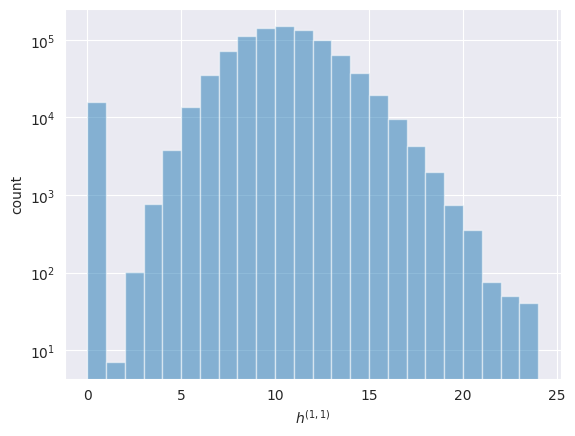

In [8]:
plt.hist(hodge[:,0], bins=range(h11min, h11max+1), alpha=0.5)
plt.xlabel('$h^{(1,1)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h11hist.pdf'))

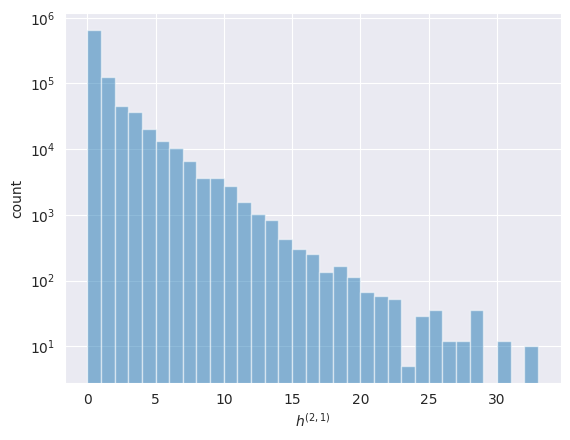

In [9]:
plt.hist(hodge[:,1], bins=range(h21min, h21max+1), alpha=0.5)
plt.xlabel('$h^{(2,1)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h21hist.pdf'))

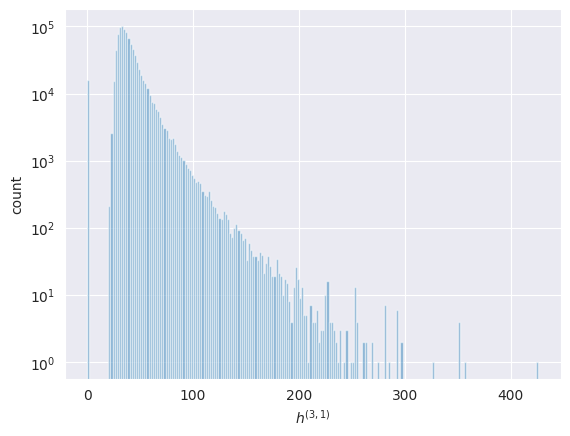

In [10]:
plt.hist(hodge[:,2], bins=range(h31min, h31max+1, 2), alpha=0.5)
plt.xlabel('$h^{(3,1)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h31hist.pdf'))

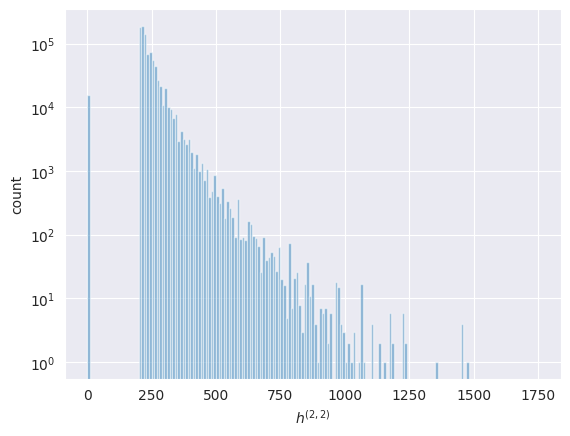

In [11]:
plt.hist(hodge[:,3], bins=range(h22min, h22max+1,10), alpha=0.5)
plt.xlabel('$h^{(2,2)}$')
plt.ylabel('count')
plt.yscale('log')
plt.savefig(os.path.join('plots', 'z-h22hist.pdf'))

# Custom data generator

In [12]:
X = conf
h11 = hodge[:,0]
y = h11

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
X_train,  X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101, shuffle = True)


X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))

X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([737197, 16, 20]),
 torch.Size([737197, 1]),
 torch.Size([184300, 16, 20]),
 torch.Size([184300, 1]))

In [13]:
def data_generator(X, y, bs = 128):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y))/bs)
    for i in range(n_batches):
    #this is to account for the last batch
    #which may not be a full size batch
        end = min((i+1)*bs, len(y))

        X_batch = X[i*bs:end]
        y_batch = y[i*bs:end]
        
        #do not use 'return' since this is a data generator
        yield X_batch, y_batch

In [14]:
for inputs, targets in data_generator(X_train, y_train):
    print('INPUTS:' 'shape:', inputs.shape, '\n inputs:', inputs[:1])
    print('TARGETS:' 'shape:', targets.shape, '\n targets:', targets[:1])
    break

INPUTS:shape: torch.Size([128, 16, 20]) 
 inputs: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.1667,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.00

In [15]:
train_gen = lambda: data_generator(X_train, y_train)
test_gen = lambda: data_generator(X_test, y_test)

# Training loop

In [16]:
def batch_gd(model, criterion, optimizer, epochs, batch_size=128, cnn = False):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    t0 = datetime.now()
    train_loss = []
    for inputs, target in train_gen():
        if cnn:
            #cnn input is N x C x Hx W
            inputs = inputs.view(batch_size,1,16,20)
        #if rnn:
            #rnn inputs is N x T x D (T: time steps, D: input size)
           # inputs = inputs.view(batch_size, 16, 20)
        inputs, target = inputs.to(device), target.to(device)

        optimizer.zero_grad()
        out = model(inputs)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        out = model(inputs)
        loss = criterion(out, target)
        test_loss.append(loss.item())
        
    test_loss = np.mean(test_loss)

    train_losses[i] = train_loss
    test_losses[i] = test_loss

    dt = datetime.now()-t0
    if i%10==0:
        print(f'Epoch: {i}/{epochs}, train loss: {train_loss: .4f}\
              test_loss: {test_loss: .4f}, duration: {dt}')
  return train_losses, test_losses

In [17]:
def calc_accuracy(model, cnn = False):
    model.eval()
    n_correct = 0.
    n_total = 0.
    batch_size =128
    for inputs, target in train_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        #Perform the prediction
        #round up the prediction to the nearest integer
        ypred = torch.round(model(inputs))
        # update counts
        n_correct += (ypred == target).sum().item()
        n_total += target.shape[0]
    train_acc = n_correct / n_total
    
    #TEST SET
    n_correct = 0.
    n_total = 0
    for inputs, target in test_gen():
        if cnn:
            inputs = inputs.view(batch_size,1,16,20)
        inputs, target = inputs.to(device), target.to(device)
        
        # Forward pass
        ypred_test = torch.round(model(inputs))
        # update counts
        n_correct += (ypred_test == target).sum().item()
        n_total += target.shape[0]
        
        test_acc = n_correct / n_total

    return train_acc, test_acc

In [18]:
def plot_losses(train_losses, test_losses):
    # Plot the train loss and test loss per iteration
    plt.plot(train_losses, label='train loss')
    plt.plot(test_losses, label='test loss')
    plt.legend()
    plt.show()

In [19]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# ANN model

In [21]:
class ANN_cicy4_h11(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(320,1024) 
        self.linear2 = nn.Linear(1024,512)
        self.linear3 = nn.Linear(512,256)
        self.linear4 = nn.Linear(256,128)
        self.linear5 = nn.Linear(128,1)

    def forward(self,x):
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        
        return x

In [22]:
model = ANN_cicy4_h11()
model.to(device)

ANN_cicy4_h11(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=320, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=128, bias=True)
  (linear5): Linear(in_features=128, out_features=1, bias=True)
)

In [23]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

  327680
    1024
  524288
     512
  131072
     256
   32768
     128
     128
       1
________
 1017857


In [24]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')

print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')

X = model.flat(X)
print(f'Original shape of the image after passing through {model.flat}: \n {X.shape}\n')

X = model.linear1(X)
print(f'Shape of the image after passing through the {model.linear1}: \n {X.shape}\n')

X = model.linear2(X)
print(f'Shape of the image after passing through the {model.linear2}: \n {X.shape}\n')

X = model.linear3(X)
print(f'Shape of the image after passing through the {model.linear3}: \n {X.shape}\n')

X = model.linear4(X)
print(f'Shape of the image after passing through the {model.linear4}: \n {X.shape}\n')

X = model.linear5(X)
print(f'Shape of the image after passing through the {model.linear5}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Original shape of the image after passing through Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 320])

Shape of the image after passing through the Linear(in_features=320, out_features=1024, bias=True): 
 torch.Size([1, 1024])

Shape of the image after passing through the Linear(in_features=1024, out_features=512, bias=True): 
 torch.Size([1, 512])

Shape of the image after passing through the Linear(in_features=512, out_features=256, bias=True): 
 torch.Size([1, 256])

Shape of the image after passing through the Linear(in_features=256, out_features=128, bias=True): 
 torch.Size([1, 128])

Shape of the image after passing through the Linear(in_features=128, out_features=1, bias=True): 
 torch.Size([1, 1])



In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [26]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, 50, 128, cnn=False)

Epoch: 0/50, train loss:  3.1988              test_loss:  2.0024, duration: 0:00:13.777824
Epoch: 10/50, train loss:  0.1832              test_loss:  0.2499, duration: 0:00:13.149324
Epoch: 20/50, train loss:  0.0691              test_loss:  0.1435, duration: 0:00:13.379903
Epoch: 30/50, train loss:  0.0398              test_loss:  0.1113, duration: 0:00:13.223703
Epoch: 40/50, train loss:  0.0288              test_loss:  0.1054, duration: 0:00:13.083585


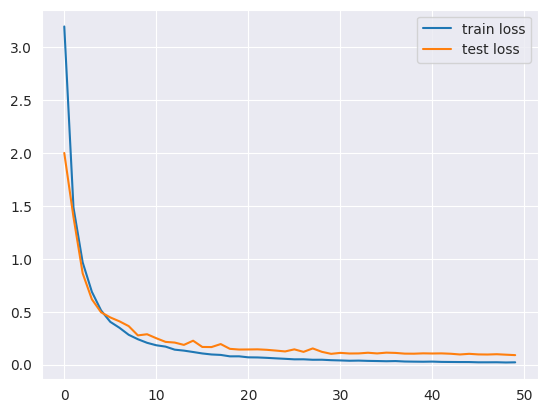

In [27]:
plot_losses(train_losses, test_losses)

In [28]:
train_acc, test_acc = calc_accuracy(model, cnn= False)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9892, Test acc: 0.9742


In [29]:
#PRINT OUT SOME OUTPUTS TO COMPARE BETWEEN PREDICTIONS AND TARGETS
for inputs, target in train_gen():
    inputs, target = inputs.to(device), target.to(device)
    #Perform the prediction
    #ypred = torch.round(model(inputs))
    ypred = (model(inputs))
    print(target[:5])
    print(ypred[:5])
    break

tensor([[14.],
        [ 6.],
        [ 8.],
        [13.],
        [ 8.]], device='cuda:0')
tensor([[13.9950],
        [ 5.9707],
        [ 8.0007],
        [12.5157],
        [ 7.9831]], device='cuda:0', grad_fn=<SliceBackward0>)


In [30]:
# SAVE MODEL FOR INFERENCE
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model, '/kaggle/working/saved_models/ANN_cicy4_h11.pt')

# CNN model

In [31]:
class CNN_cicy4_h11(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,128, 4, 1)
        self.conv2 = nn.Conv2d(128,64, 3, 1)
        self.mxpool = nn.MaxPool2d(2,2)
        self.flat = nn.Flatten()
        self.conv_total = nn.Sequential(
            self.conv1,
            self.mxpool,
            self.conv2,
            self.mxpool,
        )
        self.linear1 = nn.Linear(384,512)
        self.linear2 = nn.Linear(512,256)
        self.linear3 = nn.Linear(256,1)


    def forward(self,x):
        x = F.relu(self.conv_total(x))
        x = self.flat(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        
        return x

In [32]:
model = CNN_cicy4_h11()
model.to(device)

CNN_cicy4_h11(
  (conv1): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (conv_total): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Linear(in_features=384, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=1, bias=True)
)

In [33]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

    2048
     128
   73728
      64
  196608
     512
  131072
     256
     256
       1
________
  404673


In [34]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')
print('Reshape the size to take in account the batch number')
X = X.view(1,1,16,20)
print(f'The new size is {X.shape}\n')
X = model.conv_total(X)
print(f'Shape of the image after passing through the whole convolution block: \n {X.shape}\n')

X = model.flat(X)
print(f'Shape of the image after passing through the {model.flat}: \n {X.shape}\n')

X = model.linear1(X)
print(f'Shape of the image after passing through the {model.linear1}: \n {X.shape}\n')

X = model.linear2(X)
print(f'Shape of the image after passing through the {model.linear2}: \n {X.shape}\n')

X = model.linear3(X)
print(f'Shape of the image after passing through the {model.linear3}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 1, 16, 20])

Shape of the image after passing through the whole convolution block: 
 torch.Size([1, 64, 2, 3])

Shape of the image after passing through the Flatten(start_dim=1, end_dim=-1): 
 torch.Size([1, 384])

Shape of the image after passing through the Linear(in_features=384, out_features=512, bias=True): 
 torch.Size([1, 512])

Shape of the image after passing through the Linear(in_features=512, out_features=256, bias=True): 
 torch.Size([1, 256])

Shape of the image after passing through the Linear(in_features=256, out_features=1, bias=True): 
 torch.Size([1, 1])



In [35]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [36]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, 50,  cnn=True)

Epoch: 0/50, train loss:  3.2272              test_loss:  1.6668, duration: 0:00:16.672443
Epoch: 10/50, train loss:  0.3237              test_loss:  0.3722, duration: 0:00:16.319192
Epoch: 20/50, train loss:  0.1940              test_loss:  0.2972, duration: 0:00:16.232235
Epoch: 30/50, train loss:  0.1422              test_loss:  0.2454, duration: 0:00:16.221931
Epoch: 40/50, train loss:  0.1079              test_loss:  0.1789, duration: 0:00:16.160851


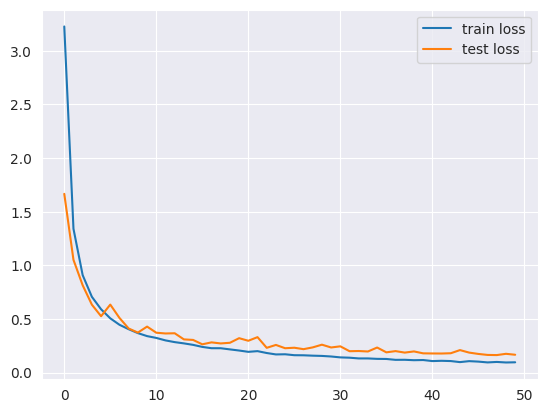

In [37]:
plot_losses(train_losses, test_losses)

In [38]:
train_acc, test_acc = calc_accuracy(model, cnn= True)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9456, Test acc: 0.9303


In [39]:
torch.save(model, '/kaggle/working/saved_models/CNN_cicy4_h11.pt')

# RNN/LSTM Model

In [40]:
class RNN_cicy4_h11(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
        super(RNN_cicy4_h11,self).__init__()
        self.D = n_inputs
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers

        self.rnn = nn.LSTM(input_size = self.D,
                           hidden_size = self.M,
                           num_layers = self.L,
                           batch_first = True)
        self.fc = nn.Linear(self.M, self.K)
       
    def forward(self, X):
         #initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        #get LSTM unit output:
        out, _ = self.rnn(X, (h0,c0))

        #we only want h(T) at the final time step
        out = self.fc(out[:, -1, :])

        return out

In [41]:
#( n_inputs, n_hidden, n_rnnlayers, n_outputs)
# n_inputs = D = # of columns: 20, T = 16
#input shape is NxTxD: Nx16x20
model = RNN_cicy4_h11(20, 80, 5, 1 )
model.to(device)

RNN_cicy4_h11(
  (rnn): LSTM(20, 80, num_layers=5, batch_first=True)
  (fc): Linear(in_features=80, out_features=1, bias=True)
)

In [42]:
#count the number of parameters in the model
params = [p.numel() for p in model.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>8}')
print(f'________\n{sum(params):>8}')

    6400
   25600
     320
     320
   25600
   25600
     320
     320
   25600
   25600
     320
     320
   25600
   25600
     320
     320
   25600
   25600
     320
     320
      80
       1
________
  240081


In [43]:
X = X_train[0].to(device)
print(f'Original shape of the image before passing through the network: \n {X.shape}\n')
print('Reshape the size to take in account the batch number')
X = X.view(1,16,20)
print(f'The new size is {X.shape}\n')

 #initial hidden states
h0 = torch.zeros(model.L, X.size(0), model.M).to(device)
c0 = torch.zeros(model.L, X.size(0), model.M).to(device)
print(f'Hidden states h0, c0: {h0.shape, c0.shape}')

X, _ = model.rnn(X, (h0, c0))
print(f'Shape of the image after passing through the {model.rnn}: \n {X.shape}\n')

X = model.fc(X)
print(f'Shape of the image after passing through the {model.fc}: \n {X.shape}\n')

Original shape of the image before passing through the network: 
 torch.Size([16, 20])

Reshape the size to take in account the batch number
The new size is torch.Size([1, 16, 20])

Hidden states h0, c0: (torch.Size([5, 1, 80]), torch.Size([5, 1, 80]))
Shape of the image after passing through the LSTM(20, 80, num_layers=5, batch_first=True): 
 torch.Size([1, 16, 80])

Shape of the image after passing through the Linear(in_features=80, out_features=1, bias=True): 
 torch.Size([1, 16, 1])



In [44]:
#PRINT OUT SOME OUTPUTS TO COMPARE BETWEEN PREDICTIONS AND TARGETS
for inputs, target in train_gen():
    inputs, target = inputs.to(device), target.to(device)
    #Perform the prediction
    #ypred = torch.round(model(inputs))
    ypred = (model(inputs))
    print(target.shape, ypred.shape)
    print(target[:5])
    print(ypred[:5])
    break

torch.Size([128, 1]) torch.Size([128, 1])
tensor([[ 7.],
        [11.],
        [ 8.],
        [10.],
        [13.]], device='cuda:0')
tensor([[0.0223],
        [0.0223],
        [0.0223],
        [0.0223],
        [0.0223]], device='cuda:0', grad_fn=<SliceBackward0>)


## Training loop for RNN

In [45]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [46]:
train_losses, test_losses=batch_gd(model, criterion, optimizer, 50,  cnn=False)

Epoch: 0/50, train loss:  7.8485              test_loss:  7.5075, duration: 0:00:21.846371
Epoch: 10/50, train loss:  0.5377              test_loss:  0.4341, duration: 0:00:21.807478
Epoch: 20/50, train loss:  0.1728              test_loss:  0.1494, duration: 0:00:21.873519
Epoch: 30/50, train loss:  0.1262              test_loss:  0.0938, duration: 0:00:21.879619
Epoch: 40/50, train loss:  0.0738              test_loss:  0.0572, duration: 0:00:21.948795


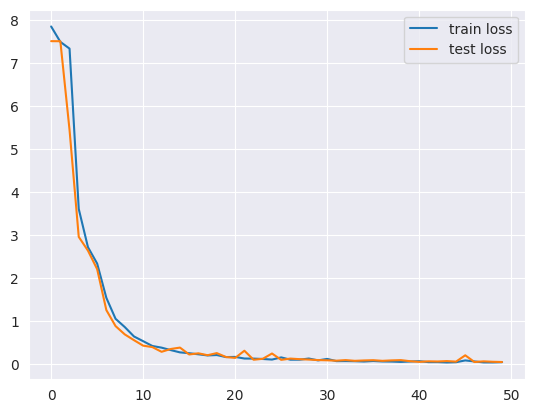

In [47]:
plot_losses(train_losses, test_losses)

In [48]:
train_acc, test_acc = calc_accuracy(model, cnn= False)
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9804, Test acc: 0.9755


In [49]:
torch.save(model, '/kaggle/working/saved_models/RNN_cicy4_h11.pt')